# 🧠🤖 Treinamento de Redes LSTM para Classificação

- **Deadline**: 24/08/2025
- **Entrega**: O trabalho deve ser entregue via sistema Testr.
- **Pontuação**: 50% da nota do T2 (+1 ponto extra).
- O trabalho deve ser realizado individualmente.



## Especificação


### Contexto

O trabalho consiste em realizar o treinamento de redes LSTM usando a base de dados [BBC News Archive disponível no kaggle](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive?select=bbc-news-data.csv). Esta base de dados contém 2.225 textos publicados no site de notícias da BBC news entre 2004-2005. Cada notícia foi classificada como sendo de um dos seguintes assuntos: business (negócios), entertainment (entretenimento), politics (política), sport (esportes), tech (tecnologia).

O objetivo do trabalho é treinar uma rede neural capaz de identificar o tema de um texto.


### Implementação

- Use o notebook de classificação de sentimentos como ponto de partida.
- use a biblioteca `kagglehub` para fazer o download do dataset no colab.
- Um dos modelos de *word embeddings* disponíveis na biblioteca `gensim` deve ser utilizado para mapear palavras em vetores.
- Use o tipo `nn.LSTM` disponível no `pytorch` (não é necessário implementar a camada LSTM do zero).
- Os dados devem ser divididos em treino, validação e teste. Use o conjunto de validação para ajustar hiperparâmetros e para selecionar o modelo com melhor generalização. Avalie o modelo resultante usando o conjunto de teste apenas ao final.
- Você pode optar por cortar os textos em um tamanho máximo (e.g., 100 palavras), como fizemos no notebook, para que os testes não demorem muito.
- Use o ambiente de `GPU` do colab para evitar que o treinamento demore excessivamente.
- Durante o desenvolvimento, é uma boa idéia usar um subconjunto (e.g., 10%) das notícias para que os testes sejam mais rápidos. Quando tudo estiver correto, faça o treinamento com a base completa.
- Deve ser plotado o gráfico mostrando a evolução da função de perda nos conjuntos de treino e validação.
- Devem ser mostradas as métricas geradas pela função `classification_report` da biblioteca scikit-learn e a matriz de confusão para o conjunto de teste.
- Faça alguns testes qualitativos com textos escritos com você (não use textos da base de dados).
- Discuta brevemente os resultados quantitativos e qualitativos (1-2 parágrafos, no máximo).



### Pontos Extras

Receberá um ponto extra, o aluno que:
- Utilizar um LLM baseado em Transformer pré-treinado (e.g., [BERT](https://medium.com/@davidlfliang/intro-getting-started-with-text-embeddings-using-bert-9f8c3b98dee6)) para mapear as notícias em *embeddings*.
- Utilizar uma rede Multilayer Perceptron para classificar os *embeddings*.
- Comparar a performance desta solução com a LSTM.

⚠️**IMPORTANTE**⚠️
- Não é necessário (nem recomendável considerando o prazo) tentar realizar *fine-tuning* do LLM pré-treinado.
- Estes modelos são SUPER-ULTRA-MASTER-BLASTER lentos na CPU. Use o ambiente de GPU do colab para evitar ficar 20h esperando para transformar os textos em *embeddings*.
- Salve os embeddings depois da geração para evitar ter que gerá-los novamente. Quando necessário, faça upload do arquivo novamente para o colab.

In [1]:
# Instalação de bibliotecas necessárias (executar apenas uma vez)
!pip install -q kagglehub gensim torch torchvision torchaudio scikit-learn
!pip install -U gensim # Problema com a biblioteca gensim para instalacao...

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from gensim.models import KeyedVectors
from gensim import downloader as api
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
import string

import os
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preparação do Dataset

In [3]:
# Download do dataset BBC News Archive usando kagglehub
# Será feito download e extração do arquivo CSV. Pode demorar alguns minutos.
import kagglehub

dataset_path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")

# Carregar o arquivo CSV em um DataFrame
csv_path = None
# Procura pelo arquivo CSV dentro do diretório baixado
for root, dirs, files in os.walk(dataset_path):
    for fname in files:
        if fname.endswith('.csv'):
            csv_path = os.path.join(root, fname)
            break
    if csv_path:
        break

assert csv_path is not None, "Arquivo CSV não encontrado no dataset"

# Carrega o DataFrame
bbc_df = pd.read_csv(csv_path, sep='\t')
bbc_df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [4]:
# Testing
# bbc_df = bbc_df.sample(frac=1/4, random_state=42)

In [5]:
# Carrega embeddings pré-treinados do Gensim.
# Utilizando o word2vec do google news pela similiradidade com o problema de classificar topicos de noticias link:https://huggingface.co/fse/word2vec-google-news-300
embedding_model = api.load('word2vec-google-news-300')

In [6]:
def clean_text(text):
    # remove pontuação
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove dígitos
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    # remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Aplica limpeza a todas as notícias
bbc_df['tokens'] = bbc_df['content'].apply(clean_text)

# Embaralha as linhas do dataset
bbc_df = bbc_df.sample(frac=1, random_state=42)

# Codifica rótulos (categorias) como inteiros
label_encoder = LabelEncoder()
bbc_df['label_id'] = label_encoder.fit_transform(bbc_df['category'])

## EDA

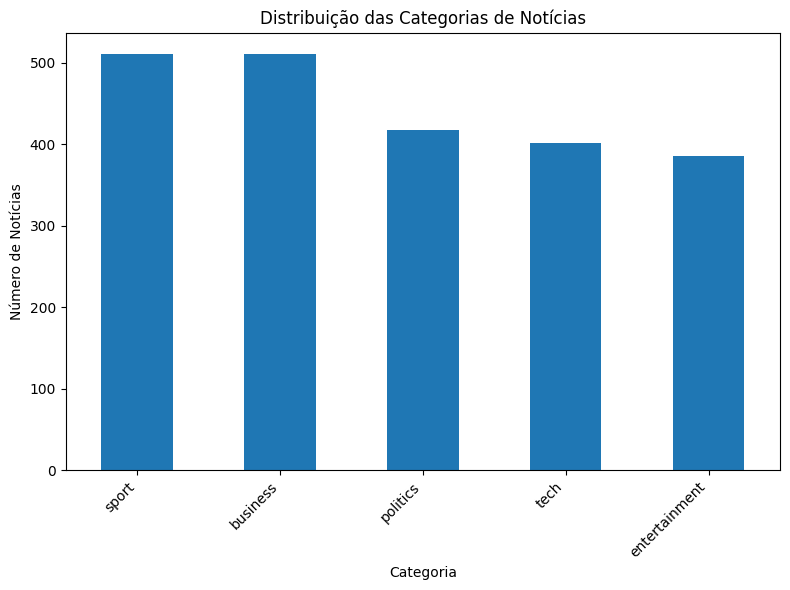

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bbc_df['category'].value_counts().plot(kind='bar')
plt.title('Distribuição das Categorias de Notícias')
plt.xlabel('Categoria')
plt.ylabel('Número de Notícias')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

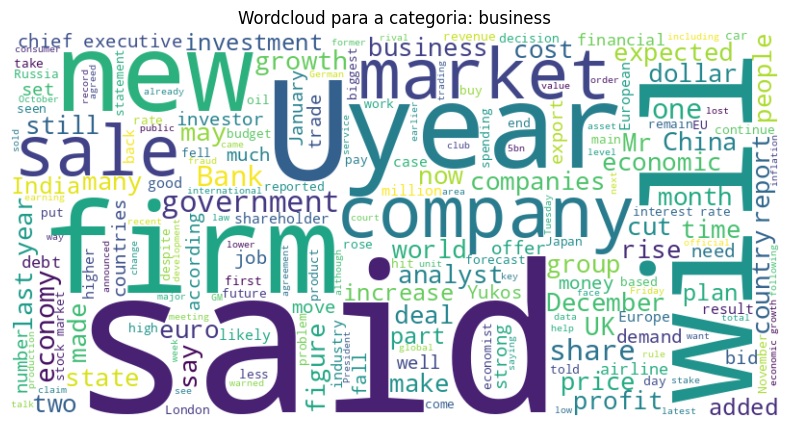

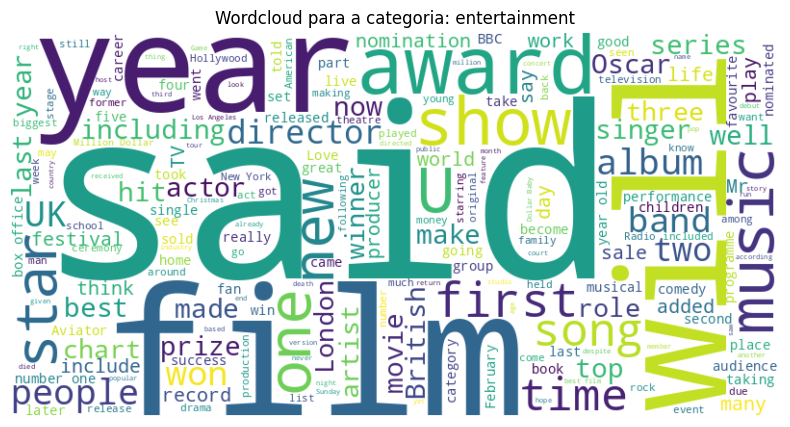

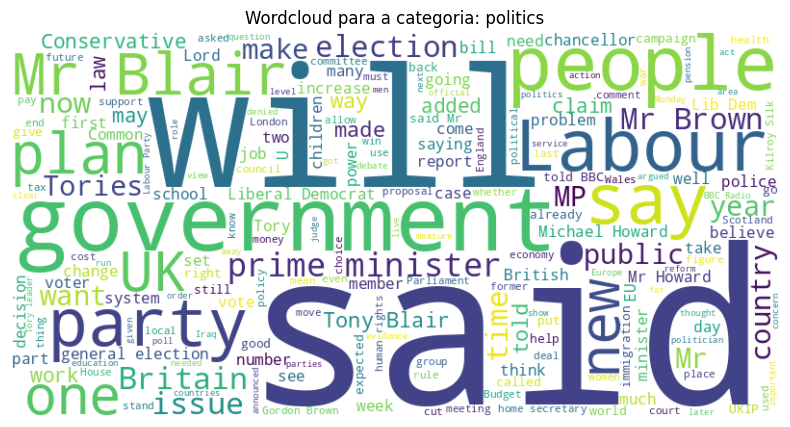

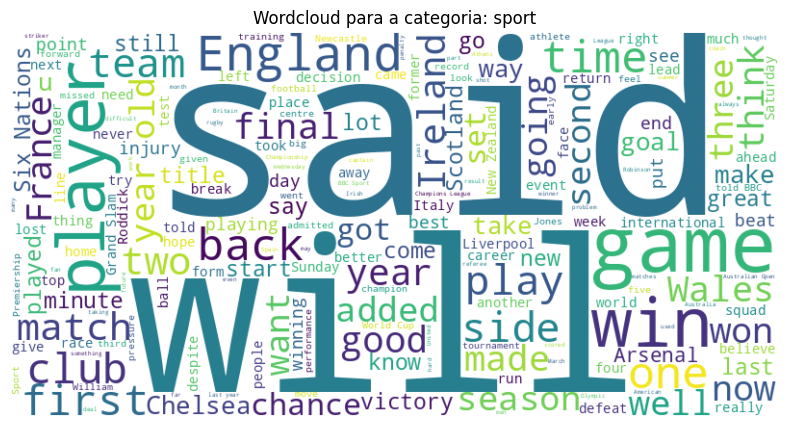

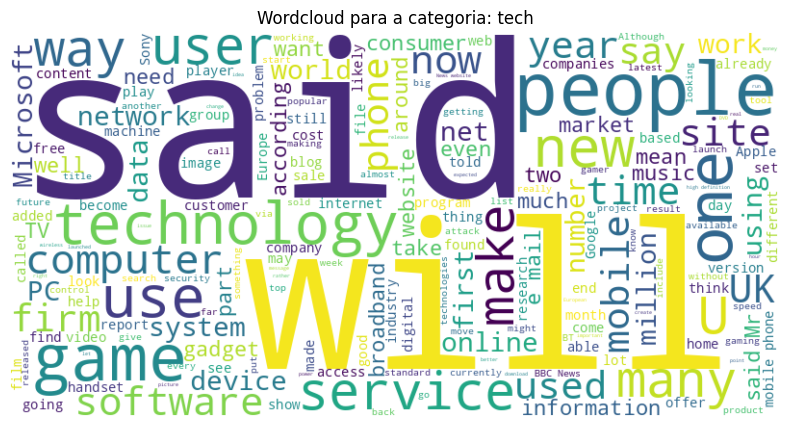

In [8]:
# Instalar a biblioteca wordcloud
!pip install -q wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Agrupar o DataFrame por categoria
grouped = bbc_df.groupby('category')['content'].apply(lambda x: ' '.join(x))

# Gerar e exibir wordcloud para cada categoria
for category, text in grouped.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud para a categoria: {category}')
    plt.show()

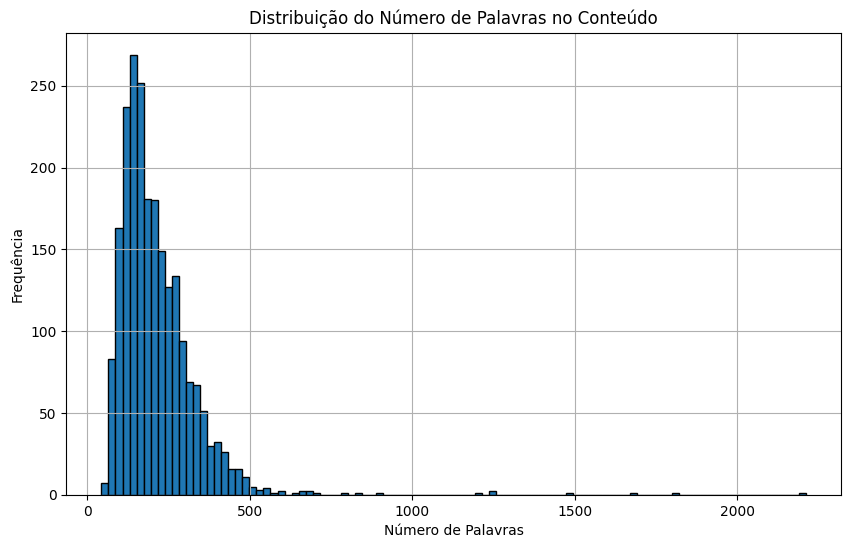


Menor conteúdo (44 palavras):
 Ex-Home Secretary David Blunkett has given fresh clues that the general election will be announced on Monday.  He told BBC Radio Five Live: "I'm out in my constituency getting ready for what we presume will be an announcement very shortly at the weekend." He clarified that he meant he would be in his Sheffield seat this weekend, not that he expected an election call then. Tony Blair is tipped to ask the Queen on Monday to dissolve Parliament ready for a 5 May poll. 

Maior conteúdo (2212 palavras):
 The Lord Chancellor has defended government plans to introduce control orders to keep foreign and British terrorist suspects under house arrest, where there isn't enough evidence to put them on trial.  Lord Falconer insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties. But thriller writer Frederick Forsyth tells BBC News of his personal respo

In [9]:
import matplotlib.pyplot as plt

# Calcula o número de palavras em cada conteúdo
bbc_df['word_count'] = bbc_df['tokens'].apply(len)

# Gera o histograma do número de palavras
plt.figure(figsize=(10, 6))
plt.hist(bbc_df['word_count'], bins=100, edgecolor='black')
plt.title('Distribuição do Número de Palavras no Conteúdo')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Encontra o índice do menor e maior conteúdo
min_len_index = bbc_df['word_count'].idxmin()
max_len_index = bbc_df['word_count'].idxmax()

# Mostra o menor conteúdo
print("\nMenor conteúdo ({} palavras):".format(bbc_df.loc[min_len_index, 'word_count']))
print(bbc_df.loc[min_len_index, 'content'])

# Mostra o maior conteúdo
print("\nMaior conteúdo ({} palavras):".format(bbc_df.loc[max_len_index, 'word_count']))
print(bbc_df.loc[max_len_index, 'content'])

## Embedding model

### Divisao Treino e Teste

In [10]:
# Comprimento máximo das sequências
max_seq_length = 100

def preprocessing(words):
    # trunca a sequencia em um tamanho máximo
    words = words[:max_seq_length]
    # converte as palavras em word embeddings descartando
    # aquelas que não existem e converte o resultado em um torch.tensor
    embds = torch.tensor(np.array([embedding_model[w] for w in words if w in embedding_model]))
    return embds

bbc_df['embeddings'] = bbc_df['tokens'].apply(preprocessing)
bbc_df['indices'] = list(pad_sequence(bbc_df['embeddings'].tolist(), batch_first=True))

# Divide o conjunto em treino, validação e teste
train_df, test_df = train_test_split(bbc_df, test_size=0.2, random_state=42, stratify=bbc_df['label_id'])
train_df, val_df  = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label_id'])

print(f"Total de amostras: {len(bbc_df)}, Treino: {len(train_df)}, Validação: {len(val_df)}, Teste: {len(test_df)}")

Total de amostras: 2225, Treino: 1602, Validação: 178, Teste: 445


In [11]:
# Dataset personalizado
class NewsDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        indices = self.df.loc[idx, 'indices']
        label = self.df.loc[idx, 'label_id']
        return indices, torch.tensor(label, dtype=torch.long)

# Cria instâncias dos datasets e DataLoaders
train_dataset = NewsDataset(train_df)
val_dataset   = NewsDataset(val_df)
test_dataset  = NewsDataset(test_df)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
class LSTMClassifier(nn.Module):
    def __init__(self):
            super().__init__()
            hidden_size = 64
            self.lstm = nn.LSTM(
                input_size=300,     # embedding size
                hidden_size=hidden_size,
                bidirectional=False,
                batch_first=True,
            )
            self.dropout = nn.Dropout(p=0.5)
            self.fc = nn.Linear(hidden_size, 5)

    def forward(self, sequence):
        _, (hidden, cell) = self.lstm(sequence)
        dropped = self.dropout(hidden.squeeze(0))
        prediction = self.fc(dropped)
        return prediction

model = LSTMClassifier()

# Define critério de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Move para GPU se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [13]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        epoch_acc += (preds == labels).sum().item()
        total += inputs.size(0)
    return epoch_loss / total, epoch_acc / total


def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            epoch_acc += (preds == labels).sum().item()
            total += inputs.size(0)
    return epoch_loss / total, epoch_acc / total

In [14]:
num_epochs = 100
best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    # Armazena os resultados no histórico
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Treino Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    # Salva o melhor modelo com base na acurácia de validação
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_lstm_model.pt')
        print("Melhor modelo salvo com acurácia de validação:", best_val_acc)

Epoch 1/100 - Treino Loss: 1.6022, Acc: 0.2447 | Val Loss: 1.5876, Acc: 0.2921
Melhor modelo salvo com acurácia de validação: 0.29213483146067415
Epoch 2/100 - Treino Loss: 1.5182, Acc: 0.3645 | Val Loss: 1.3175, Acc: 0.3933
Melhor modelo salvo com acurácia de validação: 0.39325842696629215
Epoch 3/100 - Treino Loss: 1.2208, Acc: 0.4875 | Val Loss: 1.0528, Acc: 0.5899
Melhor modelo salvo com acurácia de validação: 0.5898876404494382
Epoch 4/100 - Treino Loss: 1.1135, Acc: 0.5562 | Val Loss: 1.0709, Acc: 0.5506
Epoch 5/100 - Treino Loss: 1.0710, Acc: 0.5424 | Val Loss: 1.0279, Acc: 0.5843
Epoch 6/100 - Treino Loss: 0.9891, Acc: 0.5818 | Val Loss: 0.9981, Acc: 0.5899
Epoch 7/100 - Treino Loss: 1.0659, Acc: 0.5811 | Val Loss: 0.9939, Acc: 0.5899
Epoch 8/100 - Treino Loss: 1.1329, Acc: 0.5531 | Val Loss: 1.0887, Acc: 0.5337
Epoch 9/100 - Treino Loss: 1.0306, Acc: 0.5905 | Val Loss: 0.9938, Acc: 0.6067
Melhor modelo salvo com acurácia de validação: 0.6067415730337079
Epoch 10/100 - Treino L

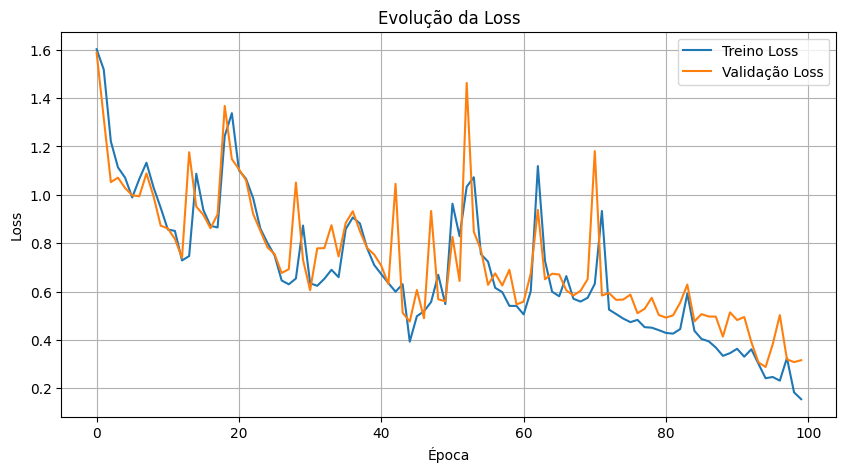

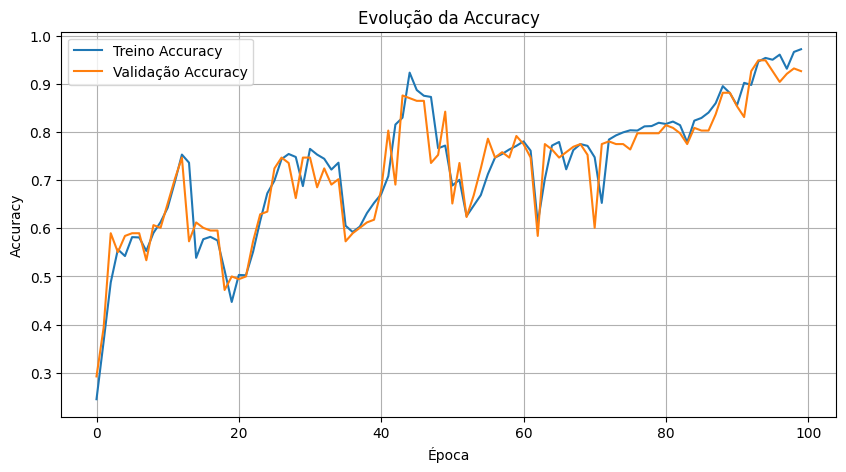

In [17]:
import matplotlib.pyplot as plt

# Gráfico de Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Treino Loss')
plt.plot(history['val_loss'], label='Validação Loss')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Treino Accuracy')
plt.plot(history['val_acc'], label='Validação Accuracy')
plt.title('Evolução da Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Carrega o melhor modelo salvo
test_model = LSTMClassifier()
test_model.load_state_dict(torch.load('best_lstm_model.pt'))
test_model = test_model.to(device)

# Avalia no conjunto de teste
test_loss, test_acc = evaluate(test_model, test_loader, criterion)
print(f"Desempenho no conjunto de teste - Loss: {test_loss:.4f}, Acurácia: {test_acc:.4f}")

Desempenho no conjunto de teste - Loss: 0.3272, Acurácia: 0.9236


In [16]:
from sklearn.metrics import classification_report
import numpy as np

all_labels = []
preds = []

model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device) # Mover labels para o device para o forward pass

        outputs = model(inputs)

        # Mover tensors para CPU antes de converter para numpy
        # Usar torch.argmax no tensor antes de converter para numpy
        cls = torch.argmax(outputs, dim=1).cpu().numpy()
        all_labels.extend(labels.cpu().numpy()) # Mover labels para CPU antes de converter para numpy
        preds.extend(cls)

print(classification_report(all_labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       102
           1       0.94      0.96      0.95        77
           2       0.94      0.87      0.90        84
           3       0.99      0.99      0.99       102
           4       0.92      0.97      0.95        80

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445

